## Interest Rate Volatility Modelling Exploration
#### 6th April 2022

First let's set up our environment.

In [1]:
# generic packages
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-deep')
clrs = sns.color_palette('deep')
%matplotlib widget
import statsmodels.api as sm
from sklearn.cluster import KMeans
from arch import arch_model
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.api as smt

# update working dir
import os
local_dir = os.path.expanduser('~/Documents/projects/rate_volatility')
os.chdir(local_dir)

# authenticate quandl
import quandl
from auth_quandl import authenticate_quandl
quandl = authenticate_quandl(quandl)


Next bring in some interest rate data and take a preliminary look

In [2]:
# load in data
rates_data = quandl.get('USTREASURY/YIELD')

# convert column names to number of days. assumes 30/360
conv = {'MO': 30, 'YR': 360}
col_labels = rates_data.columns
col_names = [int(i) * conv[j] for i, j in [x.split(' ') for x in rates_data.columns]]
rates_data.columns = col_names

rates_data

,30,60,90,180,360,720,1080,1800,2520,3600,7200,10800
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,0.03,0.13,0.22,0.49,0.78,1.18,1.39,1.62,1.75,1.79,2.17,2.11
2022-02-01,0.04,0.10,0.19,0.48,0.78,1.18,1.39,1.63,1.76,1.81,2.19,2.12
2022-02-02,0.04,0.10,0.19,0.45,0.76,1.16,1.38,1.60,1.74,1.78,2.17,2.11


Fix issue with April 14th, 2017

In [3]:
# set equal to april 13
rates_data.loc[dt.datetime(2017, 4, 14), :] = rates_data.loc[dt.datetime(2017, 4, 13), :]

### Preliminary data analysis

Plot most recent yield curve

30     0.05
60     0.12
90     0.23
180    0.56
360    0.89
Name: 2022-02-04 00:00:00, dtype: float64


Text(0, 0.5, 'Annualized Nominal Yield')

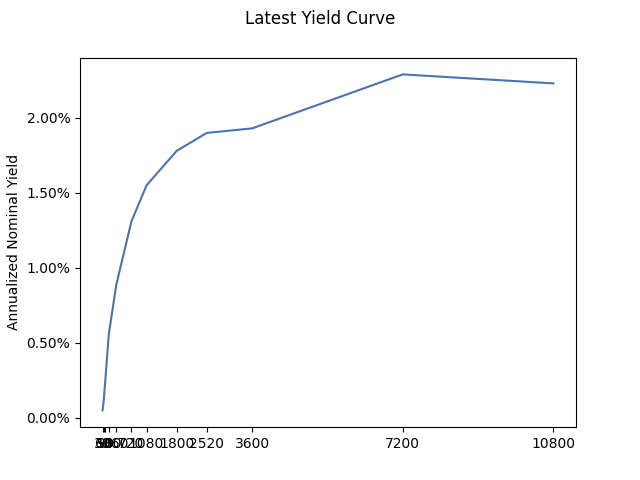

In [4]:
# subset latest data
yc = rates_data.iloc[-1, :].T
print(yc.head())

# configure plot
fig, ax = plt.subplots(1)
ax.plot(yc)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
ax.set_xticks(yc.index)
ax.set_xticklabels(rates_data.columns)
fig.suptitle('Latest Yield Curve')
ax.set_ylabel('Annualized Nominal Yield')

Plot a 3-d surface plot of the yield curve over time

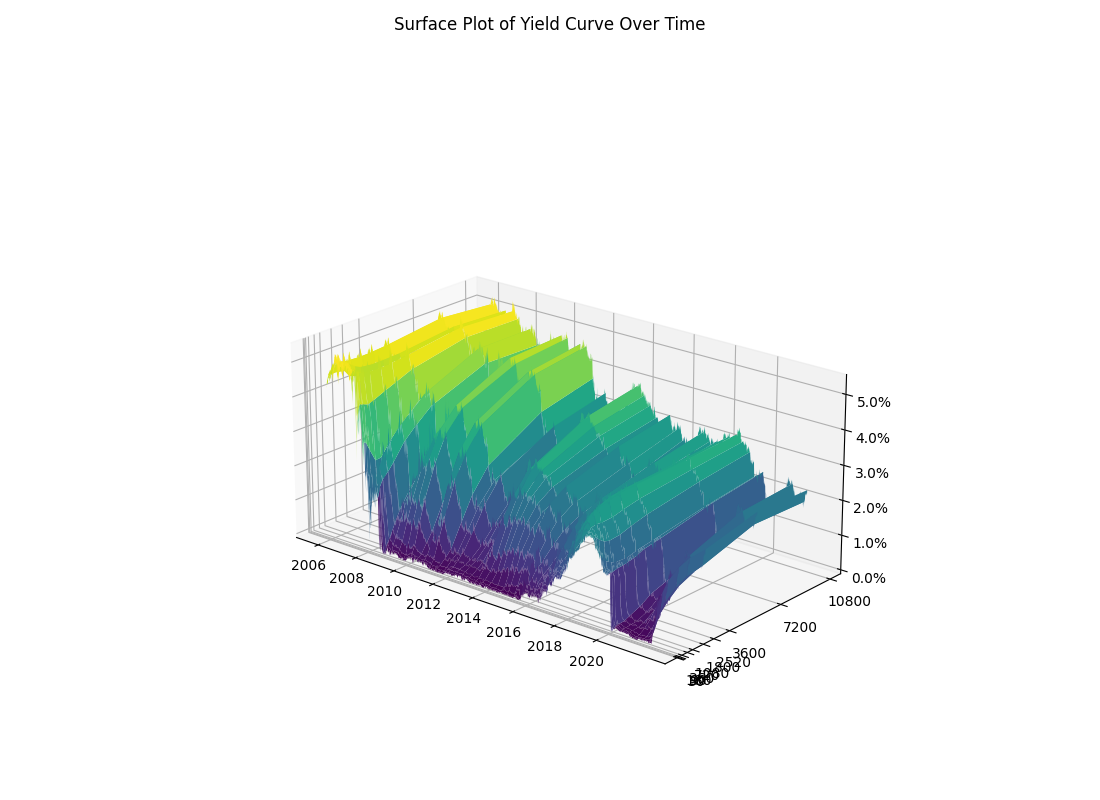

In [5]:
# subset data
start_dt = dt.datetime(2006, 2, 9)
rates_sub = rates_data[rates_data.index >= start_dt].copy()
rates_sub.drop(60, axis=1, inplace=True) # drop 2M
rates_sub.fillna(method='pad', inplace=True)

# arrange in three dimensions
X = rates_sub.columns
Y = np.arange(len(rates_sub.index))
Z = rates_sub.copy()
X, Y = np.meshgrid(X, Y)

# create plot
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, Z, cmap='viridis')

# format axes
ax.zaxis.set_major_formatter(tck.PercentFormatter())
ax.set_yticks(rates_sub.columns)
ax.set_yticklabels(rates_sub.columns)
ax.set_xticks(np.arange(0, 4000, 500))
ax.set_xticklabels([format(x, '%Y') for x in rates_sub.index[np.arange(0, 4000, 500)]])
fig.suptitle('Surface Plot of Yield Curve Over Time')

# adjust plot scaling
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.2, 0.7, 0.7, 1]))
ax.view_init(elev=20, azim=-50)

### Historical Variance Analysis

Idea here is to look at the variance of interest rates over time to see if they can be modelled.

First we plot rolling 1-year daily volatility. We'll focus on the 10-year for now

In [6]:
# isolate 10-year
yld = rates_data.loc[:, 1080].to_frame()
yld.columns = ['yield']
yld

,yield
Date,
1990-01-02,7.90
1990-01-03,7.96
1990-01-04,7.93
1990-01-05,7.94
1990-01-08,7.95
...,...
2022-01-31,1.39
2022-02-01,1.39
2022-02-02,1.38


Take first differences and plot.

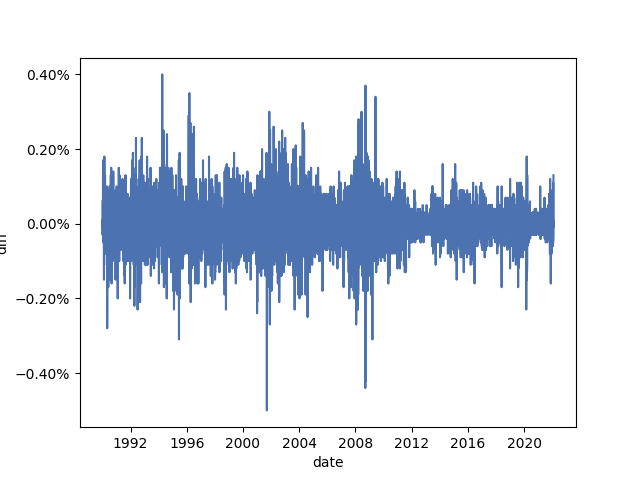

In [7]:
# first differences and clean up a bit for plotting
yld['diff'] = yld['yield'].diff()
yld.dropna(inplace=True)
yld.reset_index(inplace=True)
yld.columns = ['date','yield','diff']

# line plot of daily yield differences
fig, ax = plt.subplots(1)
sns.lineplot(data=yld, x='date', y='diff', ax=ax)
ax.yaxis.set_major_formatter(tck.PercentFormatter())

Plot rolling expanding standard deviation over time to show that volatiltiy is not constant

<AxesSubplot:xlabel='date', ylabel='value'>

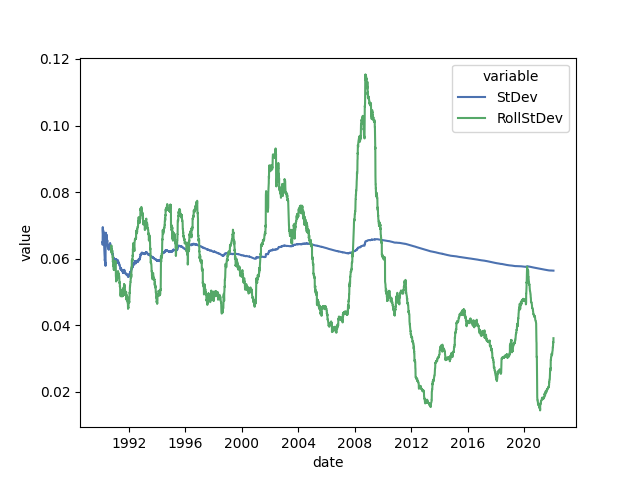

In [8]:
# compute volatility
yld['StDev'] = yld['diff'].expanding(30).std()
roll_window = 180 # 180 day volatility
yld['RollStDev'] = yld['diff'].rolling(roll_window).std() 
vols = yld.drop(['yield','diff'], axis=1).melt('date')

fig, ax = plt.subplots(1)
sns.lineplot(data=vols, x='date', y='value', hue='variable', ax=ax)

Plot histogram of daily yield changes.

<AxesSubplot:xlabel='diff', ylabel='Density'>

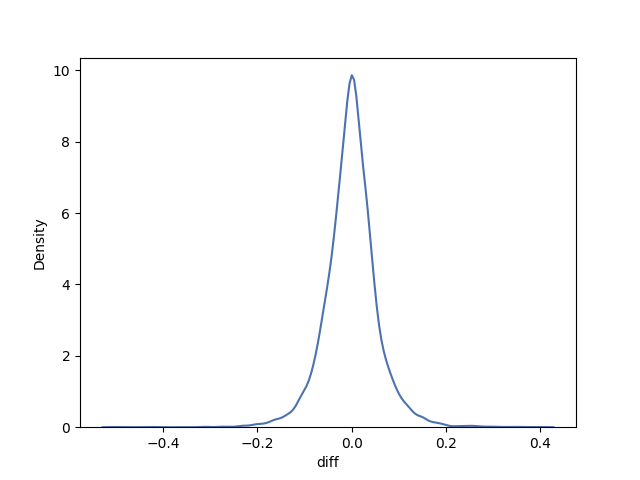

In [9]:
fig, ax = plt.subplots(1)
sns.kdeplot(data=yld, x='diff', ax=ax)

Based on the daily yield change plot the daily interest rate changes exhibit varying degrees of non-constant variance, volatility clustering, and fat tails as evidenced by the outliers in the daily return plot as well as the kernel density estimate of the distribution.

We can perform a simple volatility clustering to subset the sample into regimes.

In [10]:
# Fit 2-cluster KMeans to data
X = yld['RollStDev'].dropna().to_numpy().reshape(-1, 1)
labs = KMeans(n_clusters=2).fit(X).labels_

# append clusters to dataframe
yld['regime'] = np.tile(np.nan, yld['RollStDev'].isna().sum()).tolist() + labs.tolist()

# histogram segmented by regime
#fig, ax = plt.subplots(1)
#sns.kdeplot(data=yld, x='diff', hue='regime', ax=ax)

yld

,date,yield,diff,StDev,RollStDev,regime
0,1990-01-03,7.96,0.06,NaN,NaN,NaN
1,1990-01-04,7.93,-0.03,NaN,NaN,NaN
2,1990-01-05,7.94,0.01,NaN,NaN,NaN
3,1990-01-08,7.95,0.01,NaN,NaN,NaN
4,1990-01-09,7.94,-0.01,NaN,NaN,NaN
...,...,...,...,...,...,...
8026,2022-01-31,1.39,0.01,0.056416,0.034881,0.0
8027,2022-02-01,1.39,0.00,0.056412,0.034831,0.0
8028,2022-02-02,1.38,-0.01,0.056409,0.034848,0.0
8029,2022-02-03,1.42,0.04,0.056407,0.034940,0.0


<AxesSubplot:xlabel='date', ylabel='diff'>

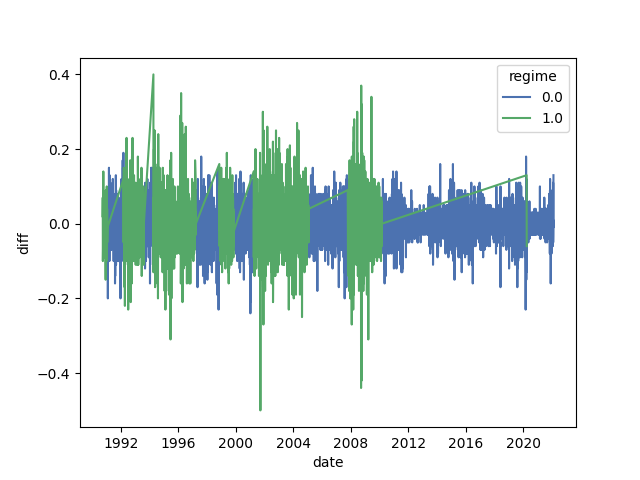

In [11]:
# lineplot segmented by regime
fig, ax = plt.subplots(1)
sns.lineplot(data=yld.dropna(), x='date', y='diff', hue='regime')

We can also visualise the tails with a QQ Plot

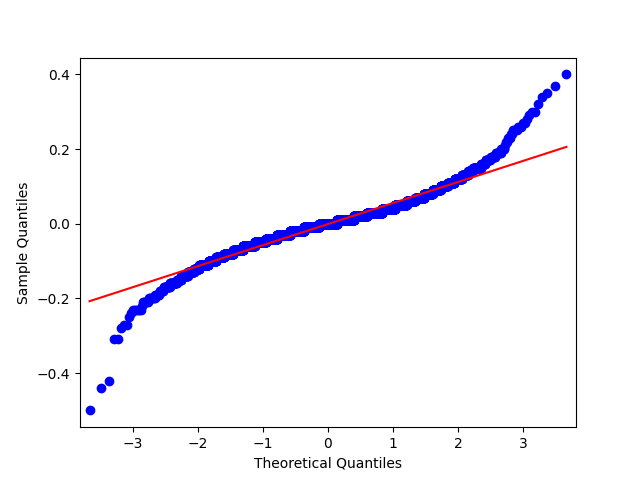

In [12]:
fig, ax = plt.subplots(1)
qq = sm.qqplot(yld['diff'], line='s', ax=ax)

### Correlation Analysis

Next we'll examine autocorrelation functions of the return series to get a better idea of dependence in the data.

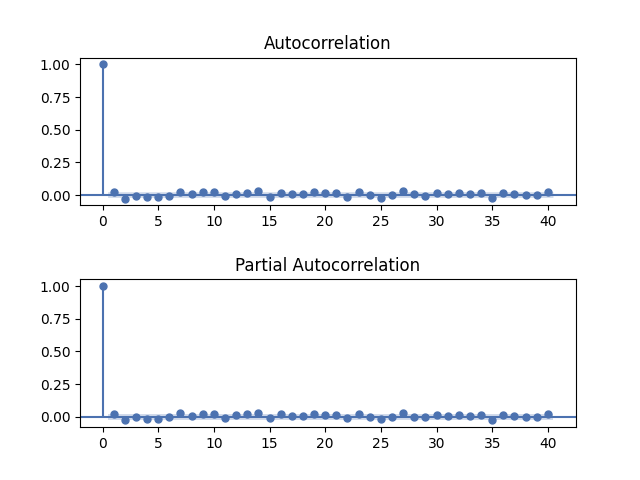

In [13]:
# plot autocorrelation function
fig, axes = plt.subplots(2)
fig.subplots_adjust(hspace=0.5)
acf = plot_acf(yld['diff'], ax=axes[0])
pacf = plot_pacf(yld['diff'], ax=axes[1])

There is almost no memory in the first differences series. Let's see if there is dependence in the variance i.e. squared first differences.

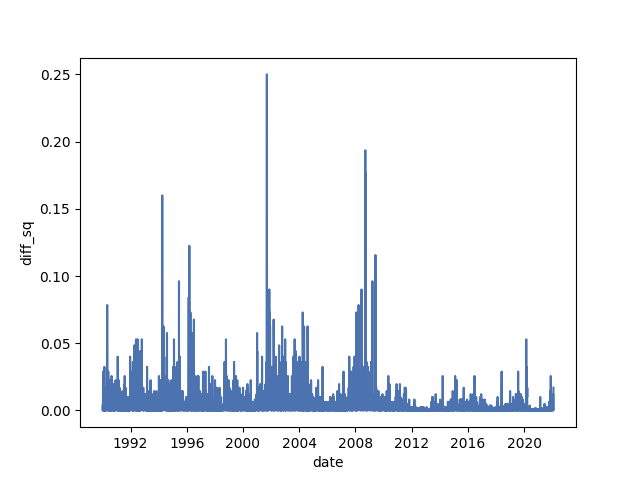

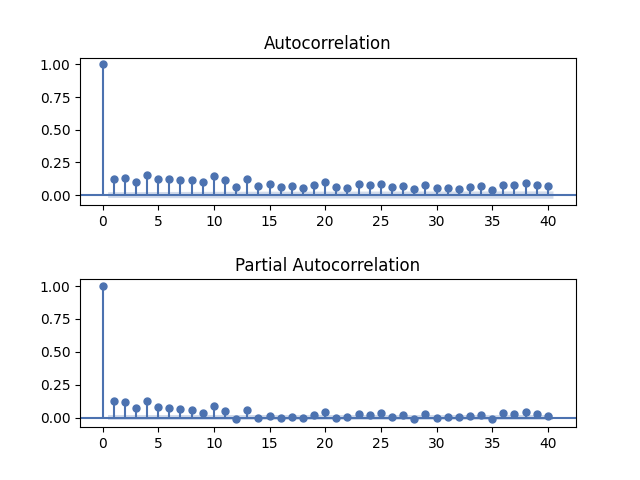

In [14]:
# square yield differences
yld['diff_sq'] = yld['diff']**2

# plot
fig, ax = plt.subplots(1)
sns.lineplot(data=yld, x='date', y='diff_sq', ax=ax)

# plot autocorrelation function
fig, axes = plt.subplots(2)
fig.subplots_adjust(hspace=0.5)
acf = plot_acf(yld['diff_sq'], ax=axes[0])
pacf = plot_pacf(yld['diff_sq'], ax=axes[1])

We now observe some weak but notable memory up to 5 or so lags.

### Volatility Modelling

<BarContainer object of 9 artists>

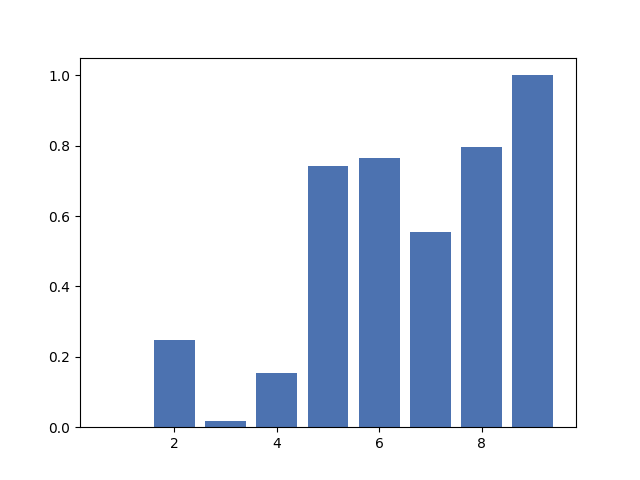

In [15]:
# clean up series and scale to 100
X = yld['diff'].dropna().to_numpy() * 100

# select spefication that gives lowest aic
aics = []
for i in range(1,10):
    gm = arch_model(X, p=i, q=i, mean='zero', vol='GARCH')
    aic = gm.fit(update_freq=5, disp='off').aic
    aics.append(aic)
    
# plot aic
aics = [(x - min(aics))/(max(aics) - min(aics)) for x in aics]
fig, ax = plt.subplots(1)
ax.bar(x=np.arange(1, 10).tolist(), height=aics)

Both 1,1 and 3,3 offer relatively low AICs.

In [16]:
gm = arch_model(X, p=1, q=1, mean='AR', vol='GARCH')
result = gm.fit(update_freq=5, disp='off')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -24198.1
Distribution:                  Normal   AIC:                           48404.3
Method:            Maximum Likelihood   BIC:                           48432.2
                                        No. Observations:                 8031
Date:                Thu, Apr 07 2022   Df Residuals:                     8030
Time:                        18:20:37   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0176  4.434e-02      0.397      0.691 [-6.929e-02,  0.105]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0523  2.531e-02      2.065  3.888e-02   [2.671e-03,  0.102]
alpha[1]       0.0477  7.145e-03      6.676  2.463e-11 [3.370e-02,6.171e-02]
beta[1]        0.9523  6.955e-03    136.930      0.000     [  0.939,  0.966]
============================================================================

Covariance estimator: robust
"""

Looks like all parameter estimates are significant.

Now that we've fit our model we can plot the modelled conditional variance

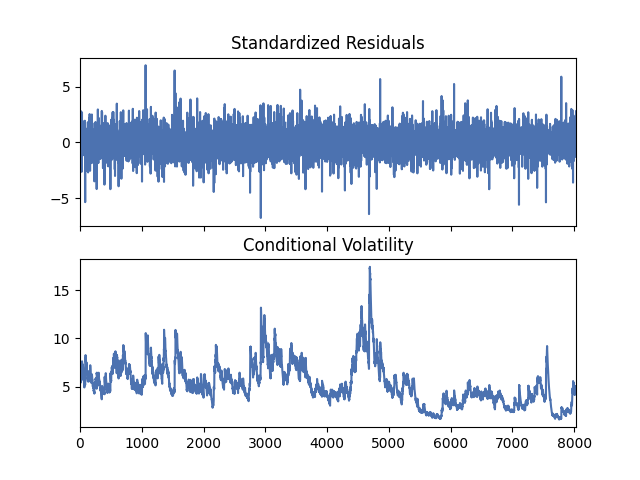

In [17]:
p = result.plot()

We examine the residuals to identify if we missed any autocorrelation effects

           date  residual
0    1990-01-03   5.98239
1    1990-01-04  -3.01761
2    1990-01-05   0.98239
3    1990-01-08   0.98239
4    1990-01-09  -1.01761
...         ...       ...
8026 2022-01-31   0.98239
8027 2022-02-01  -0.01761
8028 2022-02-02  -1.01761
8029 2022-02-03   3.98239
8030 2022-02-04  12.98239

[8031 rows x 2 columns]


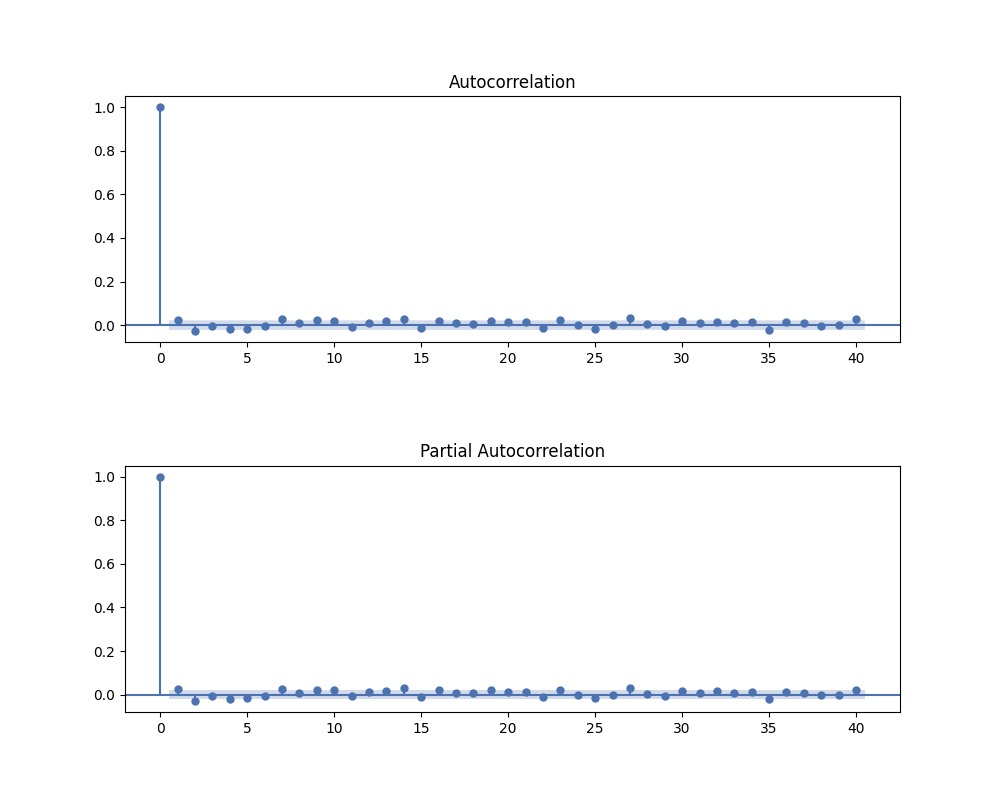

In [18]:
# Extract residuals from model
residuals = pd.DataFrame({'date': yld.date, 'residual': result.resid})
print(residuals)

# run acf and pacf on them
# plot
fig, axes = plt.subplots(2, figsize=(10,8))
fig.subplots_adjust(hspace=0.5)
acf = plot_acf(residuals['residual'], ax=axes[0])
pacf = plot_pacf(residuals['residual'], ax=axes[1])

We see very little memory present in the fitted residuals. 

As a final check we'll plot the conditional variance against the daily yield changes.

<AxesSubplot:xlabel='date', ylabel='cv'>

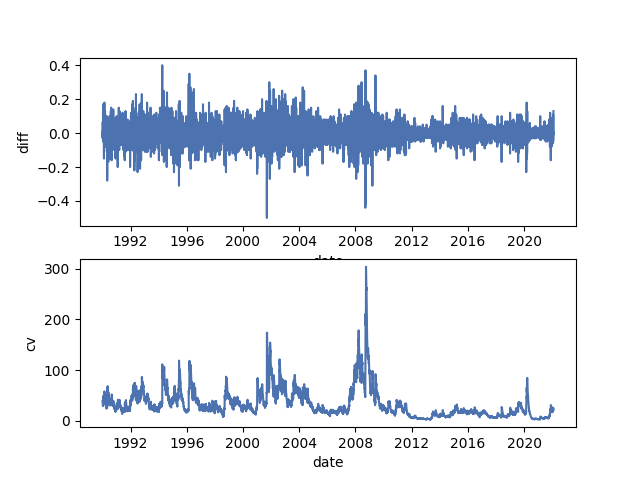

In [19]:
cond_var = pd.DataFrame({'date': yld['date'],
                         'diff': yld['diff'],
                         'cv': result.conditional_volatility**2})

fig, axes = plt.subplots(2)
sns.lineplot(data=cond_var, x='date', y='diff', ax=axes[0])
sns.lineplot(data=cond_var, x='date', y='cv', ax=axes[1])